# Preparing JUMP Cell Painting Dataset for μSplit
In this notebook we will do the following:
1. Lazy-loading the JUMP CRISPR dataset
2. Getting basic metadata about the dataset
3. Retrieving and visualizing image channels
4. Preparing images for μSplit analysis

We prepare images and combine the specified channels for the specified genes from the dataset. The JUMP datasets are designed specifically to have 5 channels, with 6 dyes to reveal 8 cellular components, via a microscopy assay called Cell Painting. You can find more information about the datasets here: https://jump-cellpainting.broadinstitute.org/


In [1]:
# Install packages and libraries
!pip install jump_deps matplotlib numpy

import os
import itertools
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from jump_portrait.fetch import get_item_location_info, get_jump_image
import matplotlib.colors as mpl
import polars as pl

In [2]:
# Function Definitions
def combine_channels_for_microsplit(
    channel_images,
    channels_to_combine=["DNA", "Mito"],
    weights=None,
    normalize=False
):
    """
    Combine multiple channels into a single image for μSplit input
    
    Parameters
    ----------
    channel_images: dict
        Dictionary containing channel names and their corresponding images
    channels_to_combine: list
        List of channel names to combine
    weights: list or None
        Optional weights for each channel
    normalize: bool
        Whether to normalize intensity values
        
    Returns
    --------
    combined_img: numpy.ndarray
        Combined image
    stats: dict
        Statistics about the combination process
    """
    processed_images = {}
    
    # Process each channel
    for channel in channels_to_combine:
        if channel not in channel_images:
            raise ValueError(f"Channel '{channel}' not found in channel_images")
            
        img = channel_images[channel].astype(np.float32)
        if normalize:
            # Avoid division by zero
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min)
            
        processed_images[channel] = img
    
    # Apply weights for combining
    if weights is None:
        weights = [1.0 / len(channels_to_combine)] * len(channels_to_combine)
    
    if len(weights) != len(channels_to_combine):
        raise ValueError(f"Number of weights ({len(weights)}) must match number of channels ({len(channels_to_combine)})")
        
    # Create combined image
    combined_img = np.zeros_like(processed_images[channels_to_combine[0]])
    for channel, weight in zip(channels_to_combine, weights):
        combined_img += processed_images[channel] * weight
    
    # Collect statistics
    stats = {
        "min_val": combined_img.min(),
        "max_val": combined_img.max(),
        "mean_val": combined_img.mean(),
        "std_val": combined_img.std()
    }
    
    return combined_img, stats


def prepare_microsplit_experiment(
    gene_list,
    output_dir="microsplit_experiment",
    images_per_gene=10,
    channels_to_combine=["DNA", "Mito"],
    weights=None,
    normalize=False,
    seed=42
):
    """
    Prepare an experiment for μSplit by combining channels and saving as TIFF files
    
    Parameters
    ----------
    gene_list: list
        List of genes to include
    output_dir: str
        Directory to save the TIFF files
    images_per_gene: int
        Number of images to retrieve per gene
    channels_to_combine: list
        Channels to combine (e.g., ["DNA", "Mito"])
    weights: list or None
        Weights for each channel (if None, equal weights are used)
    normalize: bool
        Whether to normalize intensity values
    seed: int
        Random seed for reproducibility
        
    Returns
    -------
    dict
        Information about the created experiment
    """
    # Validate inputs
    if len(channels_to_combine) < 2:
        raise ValueError("At least 2 channels must be provided to combine")
    
    # Create directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "combined"), exist_ok=True)
    for channel in channels_to_combine:
        os.makedirs(os.path.join(output_dir, channel), exist_ok=True)
    
    # Track experiment information
    experiment_info = {
        "combined_images": [],
        "original_images": {},
        "metadata": []
    }
    
    for channel in channels_to_combine:
        experiment_info["original_images"][channel] = []
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Counter for total images processed
    image_counter = 0
    
    # Process each gene
    for gene in gene_list:
        print(f"Processing gene: {gene}")
        
        # Get location info for this gene
        try:
            gene_info = get_item_location_info(gene)
        except Exception as e:
            print(f"Error getting info for gene {gene}: {str(e)}")
            continue
        
        # Filter for CRISPR perturbations
        crispr_samples = gene_info.filter(pl.col("Metadata_PlateType") == "CRISPR")
        
        # If insufficient images, skip this gene
        if crispr_samples.shape[0] < images_per_gene:
            print(f" Warning: Only {crispr_samples.shape[0]} images available for {gene}, skipping")
            continue
        
        # Randomly select images
        indices = np.random.choice(
            crispr_samples.shape[0],
            size=images_per_gene,
            replace=False
        )
        
        # Process each selected image
        for i in indices:
            try:
                row = crispr_samples.row(i)
                source = row[gene_info.columns.index("Metadata_Source")]
                batch = row[gene_info.columns.index("Metadata_Batch")]
                plate = row[gene_info.columns.index("Metadata_Plate")]
                well = row[gene_info.columns.index("Metadata_Well")]
                site = row[gene_info.columns.index("Metadata_Site")]
                
                # Get images for each channel
                channel_images = {}
                for channel in channels_to_combine:
                    img = get_jump_image(source, batch, plate, well, channel, site, None)
                    channel_images[channel] = img
                
                # Combine channels
                combined_img, stats = combine_channels_for_microsplit(
                    channel_images,
                    channels_to_combine=channels_to_combine,
                    weights=weights,
                    normalize=normalize
                )
                
                # Save combined image
                combined_filename = f"img_{image_counter:05d}_combined.tif"
                combined_path = os.path.join(output_dir, "combined", combined_filename)
                tifffile.imwrite(combined_path, combined_img)
                experiment_info["combined_images"].append(combined_path)
                
                # Save individual channel images
                for channel in channels_to_combine:
                    channel_filename = f"img_{image_counter:05d}_{channel}.tif"
                    channel_path = os.path.join(output_dir, channel, channel_filename)
                    tifffile.imwrite(channel_path, channel_images[channel])
                    experiment_info["original_images"][channel].append(channel_path)
                
                # Store metadata
                experiment_info["metadata"].append({
                    "image_id": image_counter,
                    "gene": gene,
                    "source": source,
                    "batch": batch,
                    "plate": plate,
                    "well": well,
                    "site": site,
                    "combined_channels": channels_to_combine,
                    "weights": weights,
                    "normalized": normalize,
                    "stats": stats
                })
                
                # Increment image counter
                image_counter += 1
                
            except Exception as e:
                print(f"Error processing image {i} for gene {gene}: {str(e)}")
                continue
    
    # Print summary
    print(f"Experiment created with {image_counter} images")
    print(f" - Combined images saved to: {os.path.join(output_dir, 'combined')}")
    for channel in channels_to_combine:
        print(f" - {channel} channel images saved to: {os.path.join(output_dir, channel)}")
    
    return experiment_info


def prepare_all_channel_combinations(
    gene_list,
    base_output_dir="experiments",
    images_per_gene=10,
    combination_sizes=[2],
    all_channels=["DNA", "RNA", "ER", "AGP", "Mito"],
    normalize=False,
    seed=42
):
    """
    Prepare multiple experiments for μSplit by creating all possible combinations of channels
    of specified sizes
    
    Parameters
    ----------
    gene_list: list
        List of genes to include
    base_output_dir: str
        Base directory to save all experiments
    images_per_gene: int
        Number of images to retrieve per gene
    combination_sizes: list
        List of combination sizes to generate (e.g., [2, 3] will generate
        all 2-channel and 3-channel combinations)
    all_channels: list
        List of all available channels
    normalize: bool
        Whether to normalize intensity values
    seed: int
        Random seed for reproducibility
        
    Returns
    -------
    dict
        Information about all created experiments
    """
    # Validate inputs
    for size in combination_sizes:
        if size < 2 or size > len(all_channels):
            raise ValueError(f"Combination size {size} is invalid. Must be between 2 and {len(all_channels)}.")
    
    # Dictionary to store info about created experiments
    experiments_info = {}
    
    # Make sure base directory exists
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Generate experiments for each combination size
    for combination_size in combination_sizes:
        print(f"\n{'='*50}")
        print(f"Generating experiments for {combination_size}-channel combinations")
        print(f"{'='*50}")
        
        # Create a subdirectory for this combination size
        size_dir = os.path.join(base_output_dir, f"{combination_size}_channels")
        os.makedirs(size_dir, exist_ok=True)
        
        # Generate all combinations of the specified size
        channel_combinations = list(itertools.combinations(all_channels, combination_size))
        
        # Create experiments for all combinations
        for i, channel_combination in enumerate(channel_combinations):
            # Create a descriptive name for this combination
            combination_name = "_".join([ch.lower() for ch in channel_combination])
            output_dir = os.path.join(size_dir, combination_name)
            
            print(f"\nGenerating experiment {i+1}/{len(channel_combinations)}: {' + '.join(channel_combination)}")
            
            try:
                # Create the experiment
                experiment_info = prepare_microsplit_experiment(
                    gene_list=gene_list,
                    output_dir=output_dir,
                    images_per_gene=images_per_gene,
                    channels_to_combine=list(channel_combination),
                    weights=None,
                    normalize=normalize,
                    seed=seed
                )
                
                # Store info about this experiment
                experiments_info[combination_name] = experiment_info
                
            except Exception as e:
                print(f"Error creating experiment for combination {combination_name}: {str(e)}")
                continue
    
    # Print summary
    combination_counts = {
        size: len(list(itertools.combinations(all_channels, size)))
        for size in combination_sizes
    }
    total_experiments = sum(combination_counts.values())
    
    print("\n" + "="*50)
    print(f"Summary of created experiments:")
    for size, count in combination_counts.items():
        print(f" - {count} experiments with {size}-channel combinations")
    print(f"Total: {total_experiments} experiments created")
    
    return experiments_info


def verify_experiment_structure(experiment_dir):
    """
    Verify the structure of a μSplit experiment directory.
    
    Parameters
    ----------
    experiment_dir: str
        Path to the experiment directory
        
    Returns
    -------
    bool
        True if verification passed, False otherwise
    """
    if not os.path.exists(experiment_dir):
        print(f"ERROR: Experiment directory {experiment_dir} does not exist!")
        return False
    
    # Extract channel names from directory name
    dir_name = os.path.basename(experiment_dir)
    channels_lower = dir_name.split("_")
    
    # Find the proper case for channel directories
    channel_dirs = []
    for ch in channels_lower:
        # Look for directory with matching name (ignoring case)
        found = False
        for item in os.listdir(experiment_dir):
            if item.lower() == ch.lower() and os.path.isdir(os.path.join(experiment_dir, item)):
                channel_dirs.append(item)
                found = True
                break
        if not found:
            # This is not an error if the directory name doesn't match channel names exactly
            pass
    
    # If no channel dirs found by parsing the directory name, 
    # look for any channel directories that match the available channels
    if not channel_dirs:
        all_channels = ["DNA", "RNA", "ER", "AGP", "Mito"]
        for ch in all_channels:
            if os.path.isdir(os.path.join(experiment_dir, ch)):
                channel_dirs.append(ch)
    
    # Also check combined directory
    combined_dir = os.path.join(experiment_dir, 'combined')
    if not os.path.exists(combined_dir):
        print(f"ERROR: Combined directory {combined_dir} does not exist!")
        return False
    
    # Add combined to the list of directories to check
    channels_to_check = channel_dirs + ['combined']
    
    # Count files
    file_counts = {}
    for channel in channels_to_check:
        channel_dir = os.path.join(experiment_dir, channel)
        files = [f for f in os.listdir(channel_dir) if f.endswith('.tif')]
        file_counts[channel] = len(files)
    
    # Print summary
    print(f"Experiment structure verification for: {experiment_dir}")
    print(f"{'Channel':<10} | {'File Count':<10}")
    print("-" * 25)
    for channel, count in file_counts.items():
        print(f"{channel:<10} | {count:<10}")
    
    # Verify counts match
    if len(set(file_counts.values())) == 1:
        print(f"\n✅ All channels have the same number of files: {next(iter(file_counts.values()))}")
    else:
        print(f"\n⚠️ WARNING: Channel file counts don't match!")
        return False
    
    # Sample check for matching file IDs
    combined_files = os.listdir(combined_dir)
    if combined_files:
        sample_id = combined_files[0].split('_')[1]
        print(f"\nVerifying files with ID {sample_id} exist for all channels:")
        
        for channel in channels_to_check:
            # Construct the expected filename based on the channel
            if channel == 'combined':
                expected_file = f"img_{sample_id}_combined.tif"
            else:
                expected_file = f"img_{sample_id}_{channel}.tif"
            
            file_path = os.path.join(experiment_dir, channel, expected_file)
            exists = os.path.exists(file_path)
            print(f"{expected_file:<30} : {'✅ Exists' if exists else '❌ Missing'}")
            
            if not exists:
                return False
    
    return True


def display_all_channels(source, batch, plate, well, site, title=None):
    """
    Retrieve and display all 5 channels for a specific image with their biological colors
    but preserving raw intensity values
    
    Parameters:
    -----------
    source, batch, plate, well, site: str
        Location parameters for the image
    title: str, optional
        Optional title for the figure
    """
    channels = ["DNA", "RNA", "ER", "AGP", "Mito"]
    # Dye names for each channel
    dye_names = {
        "DNA": "Hoechst 33342",
        "RNA": "SYTO 14",
        "ER": "Concanavalin A",
        "AGP": "Phalloidin/WGA", # Combined stains
        "Mito": "MitoTracker",
    }
    channel_colors = {
        "DNA": "#0000FF", # Blue
        "RNA": "#FFFF00", # Yellow
        "ER": "#00FF00", # Green
        "AGP": "#FF7F00", # Orange
        "Mito": "#FF0000", # Red
    }
    # Create figure with 6 subplots (5 channels + combined)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Store individual channel images for combining later
    channel_images = {}
    for i, channel in enumerate(channels):
        img = get_jump_image(source, batch, plate, well, channel, site, None)
        channel_images[channel] = img
        cmap = mpl.LinearSegmentedColormap.from_list(channel, ("#000", channel_colors[channel]))
        im = axes[i].imshow(img, cmap=cmap, vmin=0, vmax=None)
        axes[i].set_title(f"{channel} Channel ({dye_names[channel]})")
        axes[i].axis('off')
        cbar = plt.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Intensity', rotation=270, labelpad=15)
    
    # Create combined image using all 5 channels - with proper type conversion
    # Convert all images to float32 first for consistency
    combined_img = np.zeros_like(img, dtype=np.float32)
    for channel in channels:
        # Ensure all images are float32 before combining
        channel_data = channel_images[channel].astype(np.float32)
        combined_img += channel_data / 5.0 # Equal weighting
        
    im = axes[5].imshow(combined_img, cmap='viridis')
    axes[5].set_title("Combined (All 5 Channels)")
    axes[5].axis('off')
    cbar = plt.colorbar(im, ax=axes[5], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Intensity (a.u.)', rotation=270, labelpad=15)
    
    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return channel_images

## Let's run the notebook to combine channels and create datasets for training.
We start by loading the data, we are using the CRISPR dataset here. 

In [3]:
# Load the dataset - using CRISPR dataset here
print("=== Loading JUMP CRISPR Dataset ===")
INDEX_FILE = "https://raw.githubusercontent.com/jump-cellpainting/datasets/50cd2ab93749ccbdb0919d3adf9277c14b6343dd/manifests/profile_index.csv"
profile_index = pl.read_csv(INDEX_FILE)

# Filter for CRISPR dataset
crispr_info = profile_index.filter(pl.col("subset") == "crispr")
CRISPR_URL = crispr_info.item(0, "url")
profiles = pl.scan_parquet(CRISPR_URL)

=== Loading JUMP CRISPR Dataset ===


## Get metadata about the dataset

In [4]:
print("=== JUMP CRISPR Profile Data ===")
meta_cols = profiles.select(pl.col("^Metadata.*$")).collect_schema().names()
profile_rows = profiles.select(pl.len()).collect().item()
profile_cols = profiles.collect_schema().len()
print(f"Number of profiles: {profile_rows}")
print(f"Number of features: {profile_cols}")
print(f"Number of metadata columns: {len(meta_cols)}")

=== JUMP CRISPR Profile Data ===
Number of profiles: 51185
Number of features: 263
Number of metadata columns: 4


## Sample of unique genes in dataset

In [5]:

unique_genes = profiles.select("Metadata_JCP2022").unique().collect().to_series()
print(f"\nTotal unique perturbations: {len(unique_genes)}")
print("Sample perturbations:")
print(unique_genes.sample(5, seed=42))


Total unique perturbations: 7977
Sample perturbations:
shape: (5,)
Series: 'Metadata_JCP2022' [str]
[
	"JCP2022_803713"
	"JCP2022_800850"
	"JCP2022_801153"
	"JCP2022_800937"
	"JCP2022_804637"
]


In [6]:
# Get image information
sample_gene = "RAB30" # Using RAB30 as an example
gene_info = get_item_location_info(sample_gene)
print("\n=== JUMP Image Data ===")
print(f"Number of images for {sample_gene}: {gene_info.shape[0]}")

sample_row = gene_info.filter(pl.col("Metadata_PlateType") == "CRISPR").row(0)
source = sample_row[gene_info.columns.index("Metadata_Source")]
batch = sample_row[gene_info.columns.index("Metadata_Batch")]
plate = sample_row[gene_info.columns.index("Metadata_Plate")]
well = sample_row[gene_info.columns.index("Metadata_Well")]
site = sample_row[gene_info.columns.index("Metadata_Site")]

# Get sample image and print dimensions
sample_image = get_jump_image(source, batch, plate, well, "DNA", site, None)
print(f"Image dimensions: {sample_image.shape}")
print(f"Available channels: DNA, RNA, ER, AGP, Mito")

worker #4: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]



=== JUMP Image Data ===
Number of images for RAB30: 90
Image dimensions: (1080, 1280)
Available channels: DNA, RNA, ER, AGP, Mito


## Visualize channels for a sample image

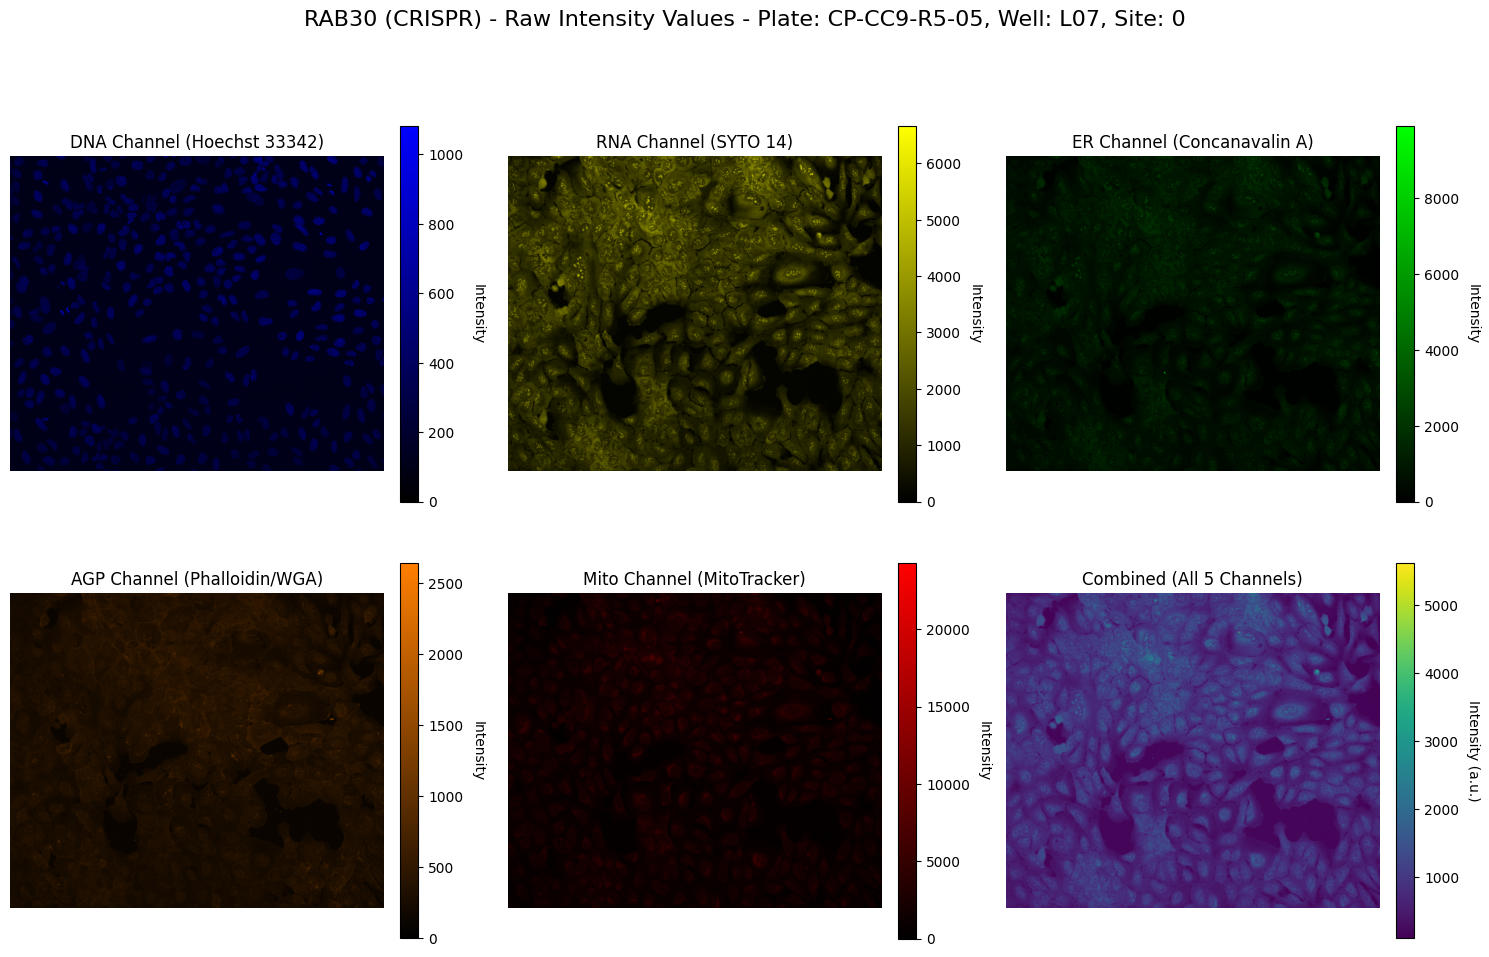

In [7]:
channel_images = display_all_channels(
    source, batch, plate, well, site,
    title=f"{sample_gene} (CRISPR) - Raw Intensity Values - Plate: {plate}, Well: {well}, Site: {site}"
)

### We need to define the list of genes to use for experiment creation. If you want to combine specific channels, you can specify them like this: " channels_to_combine=["DNA", "Mito"]". If you want to combine a a certain number of channels and generate all combinations, instead of using 'channels_to_combine', you can use "combination_sizes=[4]". This, for example, creates all 4-channel combinations (5 in total). 

In [8]:
# Define the list of genes to use for experiment creation
selected_genes = ["RAB30", "KRAS", "TP53", "EGFR", "BRCA1"]
print(f"\nSelected genes for experiment creation: {selected_genes}")


Selected genes for experiment creation: ['RAB30', 'KRAS', 'TP53', 'EGFR', 'BRCA1']


In [9]:
# Create all possible 5-channel combinations
print("\n=== Creating all possible 5-channel combinations ===")
experiments_info = prepare_all_channel_combinations(
    gene_list=selected_genes,
    base_output_dir="experiments",
    images_per_gene=5,  
    combination_sizes=[5], 
    normalize=False
)

print("\nAll datasets for your experiment have been created successfully! These can now be used with the 01_noisemodels notebook.")


=== Creating all possible 5-channel combinations ===

Generating experiments for 5-channel combinations

Generating experiment 1/1: DNA + RNA + ER + AGP + Mito
Processing gene: RAB30


worker #4: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Processing gene: KRAS


worker #1: 100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Processing gene: TP53


worker #4: 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]


Processing gene: EGFR


worker #4: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Processing gene: BRCA1


worker #4: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Experiment created with 25 images
 - Combined images saved to: experiments/5_channels/dna_rna_er_agp_mito/combined
 - DNA channel images saved to: experiments/5_channels/dna_rna_er_agp_mito/DNA
 - RNA channel images saved to: experiments/5_channels/dna_rna_er_agp_mito/RNA
 - ER channel images saved to: experiments/5_channels/dna_rna_er_agp_mito/ER
 - AGP channel images saved to: experiments/5_channels/dna_rna_er_agp_mito/AGP
 - Mito channel images saved to: experiments/5_channels/dna_rna_er_agp_mito/Mito

Summary of created experiments:
 - 1 experiments with 5-channel combinations
Total: 1 experiments created

All datasets for your experiment have been created successfully! These can now be used with the 01_noisemodels notebook.
